In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the data
df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/all_transactions.csv')

# Ensure the 'Date' is a pandas datetime object
df['Date'] = pd.to_datetime(df['date'])

Useful Statistical Methods & Indicators
1. Clustering Algorithms
What: Use unsupervised clustering (e.g., K-Means, DBSCAN, Hierarchical) on coin/project features to group coins with similar transactional/market behaviors.
Features to use: Holder concentration, owner’s share of supply, initial trading intensity, LP (liquidity pool) percentages, transaction burst patterns.
Why: Known rugs may cluster together; new coins close to these ‘risky’ clusters are more likely rugs.
2. Anomaly Detection
What: Statistical anomaly/outlier detection techniques (IsolationForest, Z-score, IQR) on transaction velocity, liquidity changes, or owner activity.
Why: Sudden abnormal spikes in withdrawals/remove liquidity/diverse sell-off often predate rugs.
3. Regression Analysis
What: Use regression to model the relationship between pre-rug characteristics (e.g., volume spikes, LP ratios, owner holdings) and rug-pull price (e.g., price at last big sell, sudden 98% drop, etc.).
Why: Allows you to estimate at what price level (range) rugs typically occur for similar coins.
4. Markov Chains/Hidden Markov Models (HMM)
What: Model state transitions in project lifecycles: launch → accumulate volume → owner sells → LP withdraw → death.
Why: Estimate probability of entering ‘rug state’ at each tick, conditioned on current observed metrics.
5. Survival Analysis
What: Time-to-event (here, rug pull) analysis; use Cox Proportional Hazards or Kaplan-Meier estimators.
Why: Find the likelihood of rug given certain features at launch or at different price levels.

Key Features from Transaction Data
Owner Holdings Through Time: Is the deployer reducing supply? Still holds >30% even after launch?
Concentration of Holders: Gini coefficient, Herfindahl Index—high concentration is risky.
Initial Liquidity Added vs. Total Market Cap
Buy/Sell Pressure Ratio: Sudden shifts (i.e., big sells clustered before a liquidity removal) are a red flag.
LP Add/Remove Events: Timestamp, size, frequency.
Transaction Frequency Spikes: Bursts followed by stagnation or mass sells is a classic rug pattern.
Honeypot Checks: Blacklist/whitelist tactics, unexpected token transfer failures.
Transfer to Exchanges: Outflow of large % of tokens to CEXes or mixing services.

Innovative Indicators to Derive:
“Deployer Stash Ratio” = (Current deployer balance / Total supply)
“Liquidity Coverage Ratio” = (Liquidity pool size / Market cap)
“Order Book Anomaly Index” = (Sum of top N sell orders / Average volume per minute) — spikes before rugs
“Transaction Velocity Drop” = (Rolling window std-dev of tx count) — drops sharply at rugs
“Social Sentiment Lag” = (Negative social sentiment spike lag vs on-chain dump observation)
“Early Whale Dump”: Detect big wallets selling within X mins/hours of launch
Python Example: Clustering & Feature Extraction
Here’s a high-level code skeleton using pandas, scikit-learn, and numpy:

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Assume df is a dataframe of coin activity with features as above.
features = ['owner_holding_pct', 'liquidity_pct', 'buy_sell_ratio',
            'top5_holder_concentration', 'lp_add_remove_spikes',
            'mean_tx_per_min', 'gini_coefficient']

X = df[features]
X_scaled = StandardScaler().fit_transform(X)

# 1. Clustering: Grouping similar coins
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

# 2. Anomaly Detection: Spot possible rugs
isf = IsolationForest(contamination=0.05)
df['rug_anomaly_score'] = isf.fit_predict(X_scaled)

# 3. Statistical Outlier for Owner Holdings
df['owner_holding_zscore'] = (df['owner_holding_pct'] - df['owner_holding_pct'].mean()) / df['owner_holding_pct'].std()

# 4. Predict rug price with regression (if labeled rug pull data is present)
from sklearn.linear_model import LinearRegression
# y = rug price / market cap at rug event; X as above
reg = LinearRegression().fit(X_scaled, df['rug_pull_price'])
df['estimated_rug_price'] = reg.predict(X_scaled)

# 5. Survival Analysis for rug-pull timing
from lifelines import CoxPHFitter
cox_df = df[['duration_until_rug', 'event_observed'] + features]  # event_observed = 1 if rug, 0 otherwise
cph = CoxPHFitter().fit(cox_df, 'duration_until_rug', event_col='event_observed')
df['rug_pull_risk'] = cph.predict_partial_hazard(df[features])

KeyError: "None of [Index(['owner_holding_pct', 'liquidity_pct', 'buy_sell_ratio',\n       'top5_holder_concentration', 'lp_add_remove_spikes', 'mean_tx_per_min',\n       'gini_coefficient'],\n      dtype='object')] are in the [columns]"

In [19]:
import pandas as pd
import numpy as np

df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Choose a Mint (coin) to analyze
mint_id = df['Mint'].unique()[0]
df_mint = df[df['Mint'] == mint_id].sort_values('Date')

# Feature engineering: rolling window stats (example: last 5 trades)
window = 5
df_mint['rolling_SOL_in'] = df_mint['SOL Amount'].rolling(window).sum().fillna(0)
df_mint['rolling_THS_price_change'] = df_mint['THS USD Price'].pct_change().fillna(0)
df_mint['is_sell'] = (df_mint['Type'] == 'sell').astype(int)  # 1 = sell, 0 = buy

# Assemble features for HMM
X = df_mint[['rolling_SOL_in', 'rolling_THS_price_change', 'is_sell']].values

df_mint['rolling_buy_ratio'] = df_mint['Type'].eq('buy').rolling(window).mean().fillna(0)
# Example of rolling_price_slope using linear regression:
from scipy.stats import linregress
def rolling_slope(series, window=5):
    result = []
    for i in range(len(series)):
        if i < window:
            result.append(0)
        else:
            y = series.iloc[i-window:i]
            x = np.arange(window)
            slope, *_ = linregress(x, y)
            result.append(slope)
    return pd.Series(result, index=series.index)

df_mint['rolling_price_slope'] = rolling_slope(df_mint['THS USD Price'], window=5)

In [20]:
from hmmlearn.hmm import GaussianHMM

# Set number of states: 2 = 'normal trading', 'anomalous/rug'
# model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=42)
model.fit(X)

# Decode the hidden states over time
hidden_states = model.predict(X)
df_mint['hidden_state'] = hidden_states


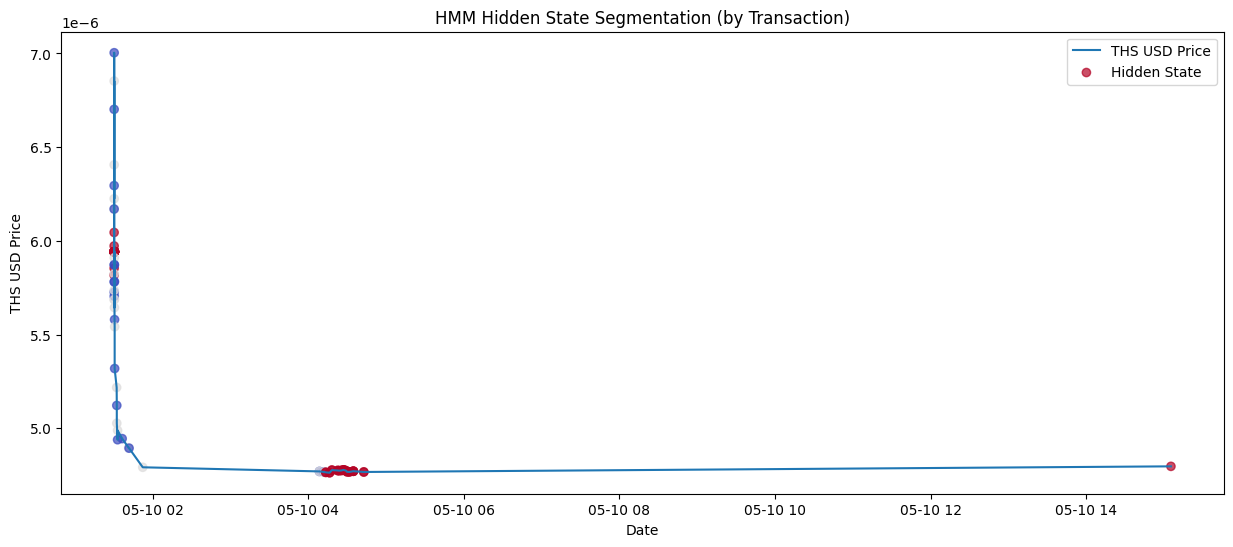

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.plot(df_mint['Date'], df_mint['THS USD Price'], label='THS USD Price')
plt.scatter(df_mint['Date'], df_mint['THS USD Price'],
            c=df_mint['hidden_state'], cmap='coolwarm', label='Hidden State', alpha=0.7)
plt.legend()
plt.title('HMM Hidden State Segmentation (by Transaction)')
plt.xlabel('Date')
plt.ylabel('THS USD Price')
plt.show()

In [24]:
state_means = []
for i in range(model.n_components):
    state_mask = df_mint['hidden_state'] == i
    state_means.append(df_mint[state_mask][['rolling_SOL_in','rolling_THS_price_change','is_sell']].mean())
    print(f"State {i} means:\n", state_means[-1])

for i in range(model.n_components):
    state_mask = df_mint['hidden_state'] == i
    state_means = df_mint[state_mask][['rolling_SOL_in','rolling_THS_price_change','rolling_buy_ratio','rolling_price_slope']].mean()
    print(f"State {i} means:\n", state_means)

State 0 means:
 rolling_SOL_in              1.325152
rolling_THS_price_change   -0.001129
is_sell                     0.400000
dtype: float64
State 1 means:
 rolling_SOL_in              1.572125
rolling_THS_price_change   -0.008368
is_sell                     0.666667
dtype: float64
State 2 means:
 rolling_SOL_in              0.000038
rolling_THS_price_change    0.000650
is_sell                     0.478261
dtype: float64


In [69]:
#Rug Pull detector
import pandas as pd
import numpy as np

# === PARAMETERS ===
ATH_LOOKBACK_WINDOW = '2H'   # Look for ATH/rug pairs within this time window (tweakable!)
DRAWDOWN_THRESHOLD = 0.8     # Rug if price falls >80% from max (0.8 = 80%)
RETURN_TO_START_EPSILON = 0.05  # Allowable difference, as a fraction of (max-min), to consider "returned to start"

# === LOAD DATA ===
df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

results = []
for mint in df['Mint'].unique():
    dfm = df[df['Mint'] == mint].sort_values('Date')
    if len(dfm) < 10:
        continue  # Not enough data for a verdict

    timestamps = dfm['Date']
    prices = dfm['THS USD Price'].values
    launch_price = prices[0]
    min_price = np.min(prices)
    max_price = np.max(prices)
    max_idx = np.argmax(prices)
    t_max = timestamps.iloc[max_idx]

    # Find lowest price after max ATH, within window
    post_max = dfm.iloc[max_idx:]
    t_start = t_max
    t_end = t_max + pd.Timedelta(ATH_LOOKBACK_WINDOW)
    post_max = post_max[post_max['Date'] <= t_end]

    if len(post_max) < 2:
        continue

    post_prices = post_max['THS USD Price'].values
    min_post_price = np.min(post_prices)
    min_post_idx = np.argmin(post_prices)
    t_min_post = post_max['Date'].iloc[min_post_idx]

    # Calculate rug features
    drawdown = (max_price-min_post_price)/max_price if max_price > 0 else 0
    returned_to_start = (abs(min_post_price-launch_price) <= RETURN_TO_START_EPSILON * (max_price - min_price))

    rug_detected = (drawdown > DRAWDOWN_THRESHOLD) #and (returned_to_start or min_post_price <= launch_price * 1.05)

    results.append({
        'Mint': mint,
        'rug_pull_detected': int(rug_detected),
        'rug_pull_time': t_min_post if rug_detected else pd.NaT,
        'max_price_time': t_max,
        'price_at_start': launch_price,
        'price_at_max': max_price,
        'price_at_rug': min_post_price,
        'time_from_max_to_rug': (t_min_post-t_max).total_seconds()/60 if rug_detected else np.nan,
        'percent_drawdown': drawdown,
        'returned_to_start': returned_to_start
    })

rug_df = pd.DataFrame(results)

print('\nSample rug pulls found:')
print(rug_df[rug_df['rug_pull_detected']==1].head(10)[['Mint','rug_pull_time','max_price_time','price_at_max','price_at_rug','time_from_max_to_rug','percent_drawdown']])

rug_df.to_csv('auto_rug_labels.csv',index=False)
print('\nResults written to auto_rug_labels.csv')
print('\nCoins with rug detected:', rug_df['rug_pull_detected'].sum())


Sample rug pulls found:
                                             Mint             rug_pull_time  \
2    HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump 2025-05-10 01:48:55+00:00   
78   5t27dek5tt6jbnSoanMA5pUuUab9Sta3uXmnSJ26pump 2025-05-10 01:39:14+00:00   
85   DMGNnT2v4Uy2ba6VgWngLo2GU3YNSDFLaas93FpEpump 2025-05-10 03:13:47+00:00   
89   C7RNEw9baJ9U8AfPBubXkDKBg86jqQe1hQJaH7DZLHrK 2025-05-10 01:48:53+00:00   
99   GaTGw9MHy8kWpQPN87F9hpconfDo6jzS78YkHzzJpump 2025-05-10 02:33:05+00:00   
109  B4L4ce2rSM42LTbJBHG6DJnzeeNznRgV7NVqWxU9pump 2025-05-10 03:06:58+00:00   
140  CAY5J7NUNxwgH8sP5yGShwqKFQ4t5icMvkxP1Mw3pump 2025-05-10 01:48:27+00:00   
155   LwYrRCAMzLWjsBE3GQMnHGA8rYikniFiYhmndbDpump 2025-05-10 03:42:21+00:00   
192  4hiCxStkaCgURLp4wCV5Tk9aav3PBe2qBssBZwBupump 2025-05-10 01:43:03+00:00   
222  E1CDMo7vwK13iS66zUc1WPZijBoBcZyBnPC66YpMpump 2025-05-10 03:31:57+00:00   

               max_price_time  price_at_max  price_at_rug  \
2   2025-05-10 01:32:44+00:00      0.000029 

In [93]:
import pandas as pd
import numpy as np
from collections import deque
from hmmlearn.hmm import GaussianHMM

# ==== CONFIGURATION ====
DATA_PATH_TRAIN = '/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv'
DATA_PATH_TEST = '/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/all_transactions.csv'
ROLL_WINDOW = 7
EARLY_MINUTE_WINDOW = 20
SKIP_N_TRADES = 10
THRESHOLDS = {
    'min_rolling_buy_for_entry': 0.6,
    'min_unique_buyers': 0,
    'min_price_slope': 0,
}
STARTING_SOL = 1
ALLOW_MULTI_ROUND = False
HMM_N_COMPONENTS = 4  # Number of HMM states

# ==== LOAD DATA ====
df = pd.read_csv(DATA_PATH_TRAIN)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


# ==== BUILD ROLLING FEATURES FOR HMM TRAINING ====
def get_hmm_X(df, roll_window=5):
    feats = []
    for mint in df['Mint'].unique():
        sub = df[df['Mint'] == mint].sort_values('Date')
        sub = sub.copy()
        sub['is_buy'] = (sub['Type'] == 'buy').astype(int)
        sub['rolling_buy_ratio'] = sub['is_buy'].rolling(roll_window).mean().fillna(0)
        # sub['rolling_tx_count'] = sub['is_buy'].rolling(roll_window).count().fillna(0)
        sub['rolling_volume'] = sub['SOL Amount'].rolling(roll_window).sum().fillna(0)
        sub['rolling_price_change'] = sub['THS USD Price'].pct_change().rolling(roll_window).mean().fillna(0)
        feats.append(sub[['rolling_buy_ratio', 'rolling_volume', 'rolling_price_change']])
    X = pd.concat(feats).dropna().values
    return X

print('Building features for HMM...')
X = get_hmm_X(df, roll_window=ROLL_WINDOW)

# ==== TRAIN HMM ====
print('Training HMM...')
model = GaussianHMM(n_components=HMM_N_COMPONENTS, covariance_type="diag", n_iter=100, random_state=42)
model.fit(X)

print('HMM state means:')
for i, mean_vec in enumerate(model.means_):
    print(f"State {i}: rolling_buy_ratio={mean_vec[0]:.3f}, rolling_volume={mean_vec[1]:.2f}, rolling_price_change={mean_vec[2]:.5f}")

# Most likely, you want to BUY in the state with highest avg rolling_buy_ratio
good_state = int(np.argmax(model.means_[:,0]))
bad_states = [i for i in range(HMM_N_COMPONENTS) if i != good_state]
print(f'Good state: {good_state}, Bad states: {bad_states}')

# ==== SIMULATED TRADER CLASS ====
class SimulatedTrader:
    def __init__(self, mint, launch_time, hmm_model, good_states, bad_states, starting_sol=1, skip_n_trades=10, allow_multi=True):
        self.mint = mint
        self.launch_time = launch_time
        self.position = 0
        self.entry_price = None
        self.cash = starting_sol
        self.total_profit = 0
        self.hold_start = None
        self.hold_end = None
        self.trades_processed = 0
        self.skip_n_trades = skip_n_trades
        self.buy_datetime = []
        self.sell_datetime = []
        self.coin_pnl = 0
        self.allow_multi = allow_multi
        self.has_traded = False
        self.locked_out = False
        self.trades = deque()
        self.window_trades = deque()
        self.hmm_model = hmm_model
        self.good_states = good_states
        self.bad_states = bad_states
        self.last_buy_time = None  # NEW: Track last buy datetime

    def add_trade(self, tx):
        self.trades.append(tx)
        self.window_trades.append(tx)
        if len(self.window_trades) > ROLL_WINDOW:
            self.window_trades.popleft()
        self.trades_processed += 1

    def calc_features(self):
        df = pd.DataFrame(list(self.trades))
        now = df['Date'].max()
        minutes_since_launch = (now - self.launch_time).total_seconds() / 60

        rolling_df = pd.DataFrame(list(self.window_trades))
        is_buy = (rolling_df['Type'] == 'buy').astype(int)
        rolling_buy_ratio = is_buy.mean() if not rolling_df.empty else 0.0
        rolling_price_change = rolling_df['THS USD Price'].pct_change().mean() if len(rolling_df) > 1 else 0.0
        rolling_volume = rolling_df['SOL Amount'].sum() if not rolling_df.empty else 0.0

        df['is_buy'] = (df['Type']=='buy').astype(int)
        early_df = df[df['Date'] <= self.launch_time + pd.Timedelta(minutes=EARLY_MINUTE_WINDOW)]
        num_unique_buyers = early_df[early_df['is_buy']==1]['From'].nunique() if 'From' in early_df else 0

        hmm_features = np.array([
            rolling_buy_ratio,
            rolling_volume,
            rolling_price_change,
        ]).reshape(1, -1)

        return {
            "mint": self.mint,
            "minutes_since_launch": minutes_since_launch,
            "rolling_buy_ratio": rolling_buy_ratio,
            "rolling_price_change": rolling_price_change,
            "rolling_volume": rolling_volume,
            "num_unique_buyers": num_unique_buyers,
            "hmm_features": hmm_features
        }

    def current_hmm_state(self, hmm_features):
        return int(self.hmm_model.predict(hmm_features)[0])

    def make_trading_decision(self, thresholds, tx):
        feats = self.calc_features()
        action = 'HOLD'
        price = tx['THS USD Price']

        if self.trades_processed <= self.skip_n_trades:
            return None

        curr_hmm_state = self.current_hmm_state(feats["hmm_features"])

        if self.locked_out:
            return None

        # Only buy if in "good" HMM state and all buy logic OK
        if feats['minutes_since_launch'] < EARLY_MINUTE_WINDOW and self.position == 0:
            if (curr_hmm_state in self.good_states and
                feats['rolling_buy_ratio'] >= thresholds['min_rolling_buy_for_entry'] and
                feats['num_unique_buyers'] >= thresholds['min_unique_buyers'] and
                feats['rolling_price_change'] >= thresholds['min_price_slope']):
                buy_amount = self.cash
                if buy_amount > 0 and price > 0:
                    self.position = buy_amount / price
                    self.cash -= buy_amount
                    self.entry_price = price
                    self.hold_start = tx['Date']
                    self.buy_datetime.append(self.hold_start)
                    self.has_traded = True
                    self.last_buy_time = tx['Date']   # Record buy time
                    action = 'BUY'

        # Sell only if at least 1 minute since last buy
        elif self.position > 0 and (curr_hmm_state in self.bad_states):
            current_time = tx['Date']
            min_hold_time_met = (
                self.last_buy_time is not None
                and (current_time - self.last_buy_time).total_seconds() >= 60
            )
            if not min_hold_time_met:
                return action  # Must hold at least 1 minute since buy
            sell_amount = self.position * price
            if sell_amount > 0:
                profit = sell_amount - (self.entry_price * self.position)
                self.total_profit += profit
                self.coin_pnl += profit
                self.cash += sell_amount
                self.hold_end = tx['Date']
                self.sell_datetime.append(self.hold_end)
                action = 'SELL'
                if not self.allow_multi:
                    self.locked_out = True
                self.position = 0
                self.entry_price = None
                self.last_buy_time = None   # Reset buy time after sell

        return action

    def force_liquidate(self, tx, final_price=None):
        if self.position > 0 and final_price:
            sell_amount = self.position * final_price
            profit = sell_amount - (self.entry_price * self.position)
            self.total_profit += profit
            self.coin_pnl += profit
            self.cash += sell_amount
            self.hold_end = tx['Date'] if hasattr(tx, 'Date') else None
            self.sell_datetime.append(self.hold_end)
            self.position = 0
            self.entry_price = None

# ==== SIMULATION LOOP ====
portfolio_pnl = 0
df = pd.read_csv(DATA_PATH_TEST)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


for mint_id in df['Mint'].unique():
    df_mint = df[df['Mint'] == mint_id].sort_values('Date')
    if df_mint.empty:
        continue
    launch_time = df_mint['Date'].min()                         # first available transaction timestamp

    sim = SimulatedTrader(
        mint_id,
        launch_time=launch_time,
        hmm_model=model,
        good_states=[good_state],
        bad_states=bad_states,
        starting_sol=STARTING_SOL,
        skip_n_trades=SKIP_N_TRADES,
        allow_multi=ALLOW_MULTI_ROUND
    )

    last_tx = None
    for i, row in df_mint.iterrows():
        tx = row.to_dict()
        last_tx = tx
        sim.add_trade(tx)
        sim.make_trading_decision(THRESHOLDS, tx)

    # Final forced liquidation if still holding after last trade
    if sim.position > 0:
        final_price = df_mint.iloc[-1]['THS USD Price']
        sim.force_liquidate(last_tx, final_price)

    if sim.buy_datetime:
        for b, s in zip(sim.buy_datetime, sim.sell_datetime):
            print(f"[{mint_id}] Buy: {b}, Sell: {s}, Coin PnL: {sim.coin_pnl:.4f} SOL, Portfolio PnL: {portfolio_pnl + sim.coin_pnl:.4f} SOL")
        if len(sim.buy_datetime) > len(sim.sell_datetime):
            print(f"[{mint_id}] Buy: {sim.buy_datetime[-1]} -> No Sell (Held to end). Coin PnL: {sim.coin_pnl:.4f} SOL, Portfolio PnL: {portfolio_pnl + sim.coin_pnl:.4f} SOL")

    portfolio_pnl += sim.coin_pnl

print(f"\n=== FINAL PORTFOLIO PnL: {portfolio_pnl:.4f} SOL ===")

Building features for HMM...
Training HMM...
HMM state means:
State 0: rolling_buy_ratio=0.471, rolling_volume=0.04, rolling_price_change=-0.00001
State 1: rolling_buy_ratio=0.558, rolling_volume=1.21, rolling_price_change=0.00002
State 2: rolling_buy_ratio=0.548, rolling_volume=4.53, rolling_price_change=-0.00053
State 3: rolling_buy_ratio=0.508, rolling_volume=16.41, rolling_price_change=0.09417
Good state: 1, Bad states: [0, 2, 3]
[SFb7r33HaDHQMjkR3Byf2Hf7KzNUombGjZHrwuRpump] Buy: 2025-05-10 11:42:39+00:00, Sell: 2025-05-10 11:43:41+00:00, Coin PnL: 0.2107 SOL, Portfolio PnL: 0.2107 SOL
[H9D1mksy8ZXdBN7RPzwkgmwWhijn3Z6bJrp54Lm2pump] Buy: 2025-05-12 09:58:23+00:00, Sell: 2025-05-12 11:22:16+00:00, Coin PnL: 4.6840 SOL, Portfolio PnL: 4.8947 SOL
[AFCWT9TWktpjYZgYBhFvdkMAHC4nEXKnPqVwqNdqpump] Buy: 2025-05-07 07:07:39+00:00, Sell: 2025-05-07 07:09:19+00:00, Coin PnL: -0.2137 SOL, Portfolio PnL: 4.6810 SOL
[3TxueMu7zGRop2FdQ4SG2nvkdUeTJLbTSmq1oakSpump] Buy: 2025-05-13 22:26:17+00:00, Sel

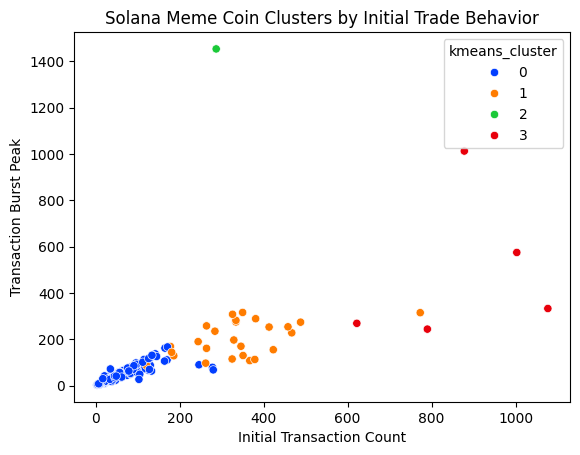

                tx_count_initial  sol_sum_initial   burst_peak
kmeans_cluster                                                
0                      35.747412        14.751848    30.569358
1                     339.538462       135.846878   202.000000
2                     287.000000       202.416226  1454.000000
3                     874.000000       462.135130   486.800000
dbscan_cluster
 0    506
-1      9
Name: count, dtype: int64

Cluster stats (mean/std/count):
                tx_count_initial                   sol_sum_initial             \
                           mean         std count            mean        std   
kmeans_cluster                                                                 
0                     35.747412   36.742323   483       14.751848  16.741400   
1                    339.538462  128.007884    26      135.846878  56.850998   
2                    287.000000         NaN     1      202.416226        NaN   
3                    874.000000  179.182867    

In [89]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# --- LOAD DATA ---
df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions500V2.csv')
df['Date'] = pd.to_datetime(df['Date'])

## --- FEATURE ENGINEERING PER COIN ---
def compute_features(df, window_minutes=10, burst_window=2):
    feature_list = []
    minters = df['Mint'].unique()
    for mint in minters:
        coin_df = df[df['Mint'] == mint].sort_values('Date')
        # Initial trading intensity
        launch_time = coin_df['Date'].min()
        mask = (coin_df['Date'] - launch_time).dt.total_seconds() < window_minutes * 60
        initial_window = coin_df[mask]
        tx_count_initial = initial_window.shape[0]
        sol_sum_initial = initial_window['SOL Amount'].sum()
        # Transaction burst pattern: highest transaction count in any burst_window-minute period
        coin_df['minute'] = (coin_df['Date'] - coin_df['Date'].min()).dt.total_seconds() // 60
        burst_counts = coin_df.groupby('minute').size()
        burst_peak = burst_counts.rolling(burst_window, min_periods=1).sum().max()

        features = {
            "Mint": mint,
            "tx_count_initial": tx_count_initial,
            "sol_sum_initial": sol_sum_initial,
            "burst_peak": burst_peak,
            # Optional: Add more features as needed
        }
        feature_list.append(features)
    return pd.DataFrame(feature_list).fillna(0)

feature_df = compute_features(df, window_minutes=10, burst_window=2)
feature_cols = ['tx_count_initial','sol_sum_initial','burst_peak']

# --- STANDARDIZE FEATURES ---
scaler = StandardScaler()
X = scaler.fit_transform(feature_df[feature_cols])

# --- CLUSTERING ---
## K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
feature_df['kmeans_cluster'] = kmeans.fit_predict(X)
## DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=4)
feature_df['dbscan_cluster'] = dbscan.fit_predict(X)

# --- VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=feature_df['tx_count_initial'], y=feature_df['burst_peak'],
                hue=feature_df['kmeans_cluster'], palette='bright')
plt.xlabel('Initial Transaction Count')
plt.ylabel('Transaction Burst Peak')
plt.title('Solana Meme Coin Clusters by Initial Trade Behavior')
plt.show()

# **Explore clusters for risk/due diligence or further analysis**
print(feature_df.groupby('kmeans_cluster')[feature_cols].mean())
print(feature_df['dbscan_cluster'].value_counts())
# Analyze cluster statistics!
cluster_stats = feature_df.groupby('kmeans_cluster')[feature_cols].agg(['mean','std','count'])
print("\nCluster stats (mean/std/count):\n", cluster_stats)

# Optionally, join with rug labels/hit curve/etc
# e.g.,
feature_df = feature_df.merge(rug_df[['Mint', 'rug_pull_detected']], on='Mint', how='left')
rugrate = feature_df.groupby('kmeans_cluster')['rug_pull_detected'].mean()
print("Cluster rug rates:", rugrate)


# Prepare the DataFrame for export
export_cols = ["Mint", "kmeans_cluster", "dbscan_cluster"]
mint_clusters = feature_df[export_cols].copy()

# Export to CSV
mint_clusters.to_csv("coin_clustering_results.csv", index=False)
print("Exported coin clustering results to coin_clustering_results.csv")

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import warnings
warnings.filterwarnings("ignore")

### 1. LOAD DATA

df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # use errors='coerce' to skip any weird dates

# Optional: Add your rug/curve labels here (list, set, DataFrame)
rugged_mints = set([
    "HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump",
    "5t27dek5tt6jbnSoanMA5pUuUab9Sta3uXmnSJ26pump",
    "DMGNnT2v4Uy2ba6VgWngLo2GU3YNSDFLaas93FpEpump",
    "C7RNEw9baJ9U8AfPBubXkDKBg86jqQe1hQJaH7DZLHrK",
    "GaTGw9MHy8kWpQPN87F9hpconfDo6jzS78YkHzzJpump",
    "B4L4ce2rSM42LTbJBHG6DJnzeeNznRgV7NVqWxU9pump",
    "CAY5J7NUNxwgH8sP5yGShwqKFQ4t5icMvkxP1Mw3pump",
    "LwYrRCAMzLWjsBE3GQMnHGA8rYikniFiYhmndbDpump",
    "4hiCxStkaCgURLp4wCV5Tk9aav3PBe2qBssBZwBupump",
    "E1CDMo7vwK13iS66zUc1WPZijBoBcZyBnPC66YpMpump",
    "9Sph88ShAWU1FDPzLHDUaMJ5xByKqXoc4n24jGecpump",
    "9PTUV7j2bwHqMmEhJyjrae6UHHaZjqS1JZWm6Am1pump",
    "9pyHcCdtLHpLegARmBCGYh3ufYC5bVtcV3ffmcQopump",
    "HovQCNKnR1CdHPgY6NDx7qAWnRBBLSvoE9H2UGxjpump",
    "A5Qav9VoRdVmih1vm9WKKLfVLiPKeBzwp9UAeZKSpump",
    "M34VFyVTt2LDFz2W6XTG4pLmM6Ja2zJhBFbKjvTpump",
    "CCJahSGzsRuT1cuHgdqrePWV9pqry2h1Rgx13eC8pump",
    "FzoYUz74i8YmzkqCHrWTbUBSyzhxSaL7FJrDmz3pump",
    "B29K873Vv4hX3UZPztJkbFhHf1bdaH4jhjRAEi3NrSKn",
    "G3vt9iyU1ep11a2qx1Pc9JuXASx6H5k2Mxmp36shpump",
    "Bb17JW3xoPm71aPqybDkS6FcJULUgLpSJGsJJCN9pump",
    "DiDrLnZB3t1pR622Lv5dWM6ZgJLiU6d6iheEstWkpump",
    "Cmqu1ypSPemLo55CkkvvgL5xcMMy58h3eBZpSTaUpump",
    "BAZ3TxHf85ineXT92KfnnBCapKyXyTzGMmDMavwnpump",
    "8ksKKTd6eG8zDnVpmMUZicFxSJZLMcnrhxB9V4WCpump",
    "9ihq7yix1ZWjcRRr9yfw2CAWzHRN1kjtqGAJ2iz1pump",
    "HzqMP87nbUijLftL1DiAfY8JGBGT3uT5ei4N4t52pump",
    "5JfALBKLHEDbEzapb2aESWLS8zxtnk5aAeURHY5Ypump",
    "Aehq4k1dm7nPmH2C2qysx7z2MiLoRHgK87RdngtFpump",
    "921Hfz8gh5sYSzkzDUMr9jEes9wg6PQoDPnvyZwHpump",
    "42vbizBtqwZLoREwb7DWhta4zWpWDTGQNYprZ9b3pump",
    "AbahLkhAFcRPkgjyEu5du7Mq7doEE5x2kjbKM2rypump",
    "CKzU76JQbWdSg2abjGsvqmfHgFTnTdNmLiDqzuqrpump",
    "DPPVDau4rCcvAoGXVSbYXBRLM9wSxEXpaCvuTSftpump",
    "EQ8WHFbdqVrWDbczwmx12Jyc9bxU8Esconwqq36qpump",
    "9w7t6mAjQdRfRJmxUSkU1pK97CsGeLQjaCtieTDfpump",
    "FLytqEtFANUSygDL5wrSxzLLPbbUfdurRx2hw2L6pump",
    "2BVSuxkbL8YBAmawvC7tgwkJGUEhZDkr82xoVUxzpump",
    "BS6qTxGi4kEMCkreXdhkjLiQ3sQZd2nCWeQhabxrpump",
    "M53FvBAHKJRkqLsYkbXtCLaak1azR5NgRRyZgHcpump",
    "AydGefgZ942it8SAWsTpinGZCKPF9eE4FXWQqDKeAzAq"
])  # Set this to your list of rug mints

curvehit_mints = set('SFb7r33HaDHQMjkR3Byf2Hf7KzNUombGjZHrwuRpump')  # Set this to your list of "hit the curve" mints

### 2. FEATURE EXTRACTION FUNCTIONS

def per_coin_features(df, window_initial=10, roll_window=5):
    """Extract early activity & general features for each coin."""
    feature_list = []
    minters = df['Mint'].unique()
    for mint in minters:
        coin_df = df[df['Mint'] == mint].sort_values('Date')
        
        if coin_df.empty or len(coin_df) < roll_window:  # skip coins with too little data
            continue

        # --- Early activity window ---
        launch_time = coin_df['Date'].min()
        mask = (coin_df['Date'] - launch_time).dt.total_seconds() < window_initial * 60
        early_df = coin_df[mask]

        # Add buy/sell masks
        coin_df['is_buy'] = (coin_df['Type'] == 'buy').astype(int)
        coin_df['rolling_buy_ratio'] = coin_df['is_buy'].rolling(roll_window).mean().fillna(0)
        coin_df['rolling_tx_count'] = coin_df['is_buy'].rolling(roll_window).count().fillna(0)
        coin_df['rolling_price_change'] = coin_df['THS USD Price'].pct_change().rolling(roll_window).mean().fillna(0)

        # Transaction burst
        coin_df['minute'] = (coin_df['Date'] - launch_time).dt.total_seconds() // 60
        burst_counts = coin_df.groupby('minute').size()
        burst_peak = burst_counts.rolling(2, min_periods=1).sum().max()

        # Unique holders (naive proxy: unique From addresses)
        num_unique_buyers = early_df[early_df['Type'] == 'buy']['From'].nunique() if 'From' in early_df.columns else np.nan

        # Owner holding proxy, if address is known - here, not implemented, but see below
        # owner_concentration = ...

        features = {
            "Mint": mint,
            "tx_count_initial": early_df.shape[0],
            "sol_sum_initial": early_df['SOL Amount'].sum(),
            "burst_peak": burst_peak,
            "mean_rolling_buy_ratio": coin_df['rolling_buy_ratio'].mean(),
            "max_rolling_buy_ratio": coin_df['rolling_buy_ratio'].max(),
            "mean_rolling_tx_count": coin_df['rolling_tx_count'].mean(),
            "max_rolling_tx_count": coin_df['rolling_tx_count'].max(),
            "mean_rolling_price_change": coin_df['rolling_price_change'].mean(),
            "max_rolling_price_change": coin_df['rolling_price_change'].max(),
            "num_tx": coin_df.shape[0],
            "num_buys": coin_df['is_buy'].sum(),
            "num_unique_buyers": num_unique_buyers,
            # Add more features if desired: e.g. top holder concentration, owner trades, etc.
        }
        feature_list.append(features)
    return pd.DataFrame(feature_list).fillna(0)

### 3. CLUSTERING

def do_clustering(feature_df, feature_cols, n_clusters=4):
    """Add KMeans and DBSCAN cluster labels to your feature DataFrame."""
    scaler = StandardScaler()
    X = scaler.fit_transform(feature_df[feature_cols])
    feature_df['kmeans_cluster'] = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)
    feature_df['dbscan_cluster'] = DBSCAN(eps=1.2, min_samples=4).fit_predict(X)
    return feature_df

### 4. LABELING (OPTIONAL)

def apply_outcome_labels(feature_df, rugged_mints=None, curvehit_mints=None):
    """Attach binary labels for rug pull and 'curve-runner' outcomes."""
    feature_df['is_rug'] = feature_df['Mint'].isin(rugged_mints).astype(int) if rugged_mints else 0
    feature_df['hit_curve'] = feature_df['Mint'].isin(curvehit_mints).astype(int) if curvehit_mints else 0
    return feature_df

### 5. RUN EVERYTHING

# Step 1: feature extraction
feature_df = per_coin_features(df, window_initial=10, roll_window=5)

# Step 2: clustering columns of interest
feature_cols = [
    'tx_count_initial','sol_sum_initial','burst_peak',
    'mean_rolling_buy_ratio','max_rolling_buy_ratio',
    'mean_rolling_tx_count','max_rolling_tx_count',
    'mean_rolling_price_change','max_rolling_price_change',
    'num_tx','num_buys','num_unique_buyers' 
]
feature_df = do_clustering(feature_df, feature_cols)

# Step 3 (optional): Rug/curve labels
feature_df = apply_outcome_labels(feature_df, rugged_mints, curvehit_mints)

# Step 4: Save to CSV for easy browsing & ML/analysis
feature_df.to_csv('pumpfun_master_features.csv', index=False)
print("Saved: pumpfun_master_features.csv")

# Step 5 (optional): Print summary stats
if 'is_rug' in feature_df.columns:    
    summary = feature_df.groupby('kmeans_cluster')[['is_rug','hit_curve']].agg(['sum','count', 'mean'])
    print("Cluster vs Outcome Summary (per cluster-group):")
    print(summary)

### END OF SCRIPT


Saved: pumpfun_master_features.csv
Cluster vs Outcome Summary (per cluster-group):
               is_rug                 hit_curve           
                  sum count      mean       sum count mean
kmeans_cluster                                            
0                   8   748  0.010695         0   748  0.0
1                  29    67  0.432836         0    67  0.0
2                   0   658  0.000000         0   658  0.0
3                   4     5  0.800000         0     5  0.0


In [43]:
import pandas as pd
from collections import deque

# --- PARAMETERS ---
ROLL_WINDOW = 5
EARLY_MINUTE_WINDOW = 20

THRESHOLDS = {
    'min_rolling_buy_for_entry': 0.6,      # e.g. only buy if recent buys are >70%
    'min_unique_buyers': 0,
    'min_price_slope': 0.00005,
    'min_rolling_buy_for_exit': 0.4
}

# --- UTILITIES ---

class SimulatedTrader:
    def __init__(self, mint, launch_time):
        self.mint = mint
        self.launch_time = launch_time
        self.trades = deque()
        self.window_trades = deque()
        self.position = 0        # 0 = no position; >0 = bought; can enhance to track buy sizes/costs
        self.trade_log = []

    def add_trade(self, tx):
        self.trades.append(tx)
        self.window_trades.append(tx)
        if len(self.window_trades) > ROLL_WINDOW:
            self.window_trades.popleft()

    def calc_features(self):
        df = pd.DataFrame(list(self.trades))
        now = df['Date'].max()
        minutes_since_launch = (now - self.launch_time).total_seconds() / 60

        # Rolling/Recent
        rolling_df = pd.DataFrame(list(self.window_trades))
        is_buy = (rolling_df['Type'] == 'buy').astype(int)
        rolling_buy_ratio = is_buy.mean() if not rolling_df.empty else 0.0
        rolling_tx_count = len(rolling_df)
        rolling_price_change = rolling_df['THS USD Price'].pct_change().mean() if len(rolling_df) > 1 else 0.0
        
        # Early Activity Features
        early_df = df[df['Date'] <= self.launch_time + pd.Timedelta(minutes=EARLY_MINUTE_WINDOW)]
        tx_count_initial = len(early_df)
        num_unique_buyers = early_df[early_df['Type']=='buy']['From'].nunique() if 'From' in early_df else 0

        return {
            "mint": self.mint,
            "minutes_since_launch": minutes_since_launch,
            "rolling_buy_ratio": rolling_buy_ratio,
            "rolling_tx_count": rolling_tx_count,
            "rolling_price_change": rolling_price_change,
            "tx_count_initial": tx_count_initial,
            "num_unique_buyers": num_unique_buyers
        }

    def make_trading_decision(self, thresholds, tx):
        feats = self.calc_features()
        action = 'HOLD'
        amount = 0.0

        # Only buy within the early window if not already in position
        if feats['minutes_since_launch'] < EARLY_MINUTE_WINDOW and self.position == 0:
            if (feats['rolling_buy_ratio'] >= thresholds['min_rolling_buy_for_entry'] and
                feats['num_unique_buyers'] >= thresholds['min_unique_buyers'] and
                feats['rolling_price_change'] >= thresholds['min_price_slope']):
                action = 'BUY'
                amount = tx['SOL Amount']  # or decide a fixed %/amount (here, simulate copying the latest trade amount)
                self.position += amount    # simple positional model

        # Sell signal (only if we have position)
        elif self.position > 0 and feats['rolling_buy_ratio'] < thresholds['min_rolling_buy_for_exit']:
            action = 'SELL'
            amount = self.position       # sell all (or set to a fraction)
            self.position = 0

        # Log this decision after this tx
        self.trade_log.append({
            **tx,
            'Decision': action,
            'BuySellAmount': amount,
            **feats
        })

        return action, amount

# --- MAIN SCRIPT ---

df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Choose coins to simulate. Here, the first Mint in the file:
# mint_id = df['Mint'].unique()[0]
# mint_id = "SFb7r33HaDHQMjkR3Byf2Hf7KzNUombGjZHrwuRpump"
# df_mint = df[df['Mint'] == mint_id].sort_values('Date')

# # Or do for all mints (see below!)

# sim = SimulatedTrader(mint_id, df_mint['Date'].min())

# for i, row in df_mint.iterrows():
#     tx = row.to_dict()
#     sim.add_trade(tx)
#     sim.make_trading_decision(THRESHOLDS, tx)

# signals_df = pd.DataFrame(sim.trade_log)
# signals_df.to_csv('simulated_trading_signals.csv', index=False)
# print("Saved simulated trading signal log to simulated_trading_signals.csv")


# --- Individual mint analytics ---
# # Look just at first early trades to see what values you get:
# print(signals_df[['rolling_buy_ratio', 'num_unique_buyers', 'rolling_price_change']].head(30))

# print("Rolling buy ratio min/max/mean:", signals_df['rolling_buy_ratio'].min(), 
#       signals_df['rolling_buy_ratio'].max(), signals_df['rolling_buy_ratio'].mean())
# print("Num unique buyers min/max/mean:", signals_df['num_unique_buyers'].min(), 
#       signals_df['num_unique_buyers'].max(), signals_df['num_unique_buyers'].mean())
# print("Rolling price change min/max/mean:", signals_df['rolling_price_change'].min(),
#       signals_df['rolling_price_change'].max(), signals_df['rolling_price_change'].mean())


# --- IF YOU WANT TO DO THIS FOR ALL COINS/MINTS IN THE FILE ---
results = []
for mint_id in df['Mint'].unique():
    df_mint = df[df['Mint'] == mint_id].sort_values('Date')
    sim = SimulatedTrader(mint_id, df_mint['Date'].min())
    for i, row in df_mint.iterrows():
        tx = row.to_dict()
        sim.add_trade(tx)
        sim.make_trading_decision(THRESHOLDS, tx)
    results.extend(sim.trade_log)
signals_df = pd.DataFrame(results)
signals_df.to_csv('simulated_trading_signals_all_coins.csv', index=False)

KeyboardInterrupt: 

In [45]:
import pandas as pd
from collections import deque

# --- PARAMETERS ---
ROLL_WINDOW = 10
EARLY_MINUTE_WINDOW = 20
SKIP_N_TRADES = 10
THRESHOLDS = {
    'min_rolling_buy_for_entry': 0.5,
    'min_unique_buyers': 0,
    'min_price_slope': 0.0,
    'min_rolling_buy_for_exit': 0.35,
    'trailing_stop_pct':0.15,
    'profit_target_pct':1.0,
}
STARTING_SOL = 1
ALLOW_MULTI_ROUND = True   # Set to False to ban re-investment in a coin after first exit

class SimulatedTrader:
    def __init__(self, mint, launch_time, starting_sol=1, skip_n_trades=10, allow_multi=True):
        self.mint = mint
        self.launch_time = launch_time
        self.position = 0
        self.entry_price = None
        self.cash = starting_sol
        self.total_profit = 0
        self.hold_start = None
        self.hold_end = None
        self.trades_processed = 0
        self.skip_n_trades = skip_n_trades
        self.buy_datetime = []
        self.sell_datetime = []
        self.coin_pnl = 0
        self.allow_multi = allow_multi
        self.has_traded = False      # Has traded at least once
        self.locked_out = False      # If False, can re-invest; if True, cannot buy again after first sell
        self.trades = deque()
        self.window_trades = deque()
        self.max_price = None
        self.trailing_stop_pct = trailing_stop_pct
        self.profit_target_pct = profit_target_pct

    def add_trade(self, tx):
        self.trades.append(tx)
        self.window_trades.append(tx)
        if len(self.window_trades) > ROLL_WINDOW:
            self.window_trades.popleft()
        self.trades_processed += 1

    def calc_features(self):
        df = pd.DataFrame(list(self.trades))
        now = df['Date'].max()
        minutes_since_launch = (now - self.launch_time).total_seconds() / 60

        rolling_df = pd.DataFrame(list(self.window_trades))
        is_buy = (rolling_df['Type'] == 'buy').astype(int)
        rolling_buy_ratio = is_buy.mean() if not rolling_df.empty else 0.0
        rolling_price_change = rolling_df['THS USD Price'].pct_change().mean() if len(rolling_df) > 1 else 0.0

        df['is_buy'] = (df['Type']=='buy').astype(int)
        early_df = df[df['Date'] <= self.launch_time + pd.Timedelta(minutes=EARLY_MINUTE_WINDOW)]
        num_unique_buyers = early_df[early_df['is_buy']==1]['From'].nunique() if 'From' in early_df else 0

        return {
            "mint": self.mint,
            "minutes_since_launch": minutes_since_launch,
            "rolling_buy_ratio": rolling_buy_ratio,
            "rolling_price_change": rolling_price_change,
            "num_unique_buyers": num_unique_buyers
        }

    def make_trading_decision(self, thresholds, tx):
        feats = self.calc_features()
        action = 'HOLD'
        price = tx['THS USD Price']

        # ENFORCE MINIMUM TRADE COUNT
        if self.trades_processed <= self.skip_n_trades:
            return None

        # LOCKOUT logic
        if self.locked_out:
            return None

        # Buy logic
        if feats['minutes_since_launch'] < EARLY_MINUTE_WINDOW and self.position == 0:
            if (feats['rolling_buy_ratio'] >= thresholds['min_rolling_buy_for_entry'] and
                feats['num_unique_buyers'] >= thresholds['min_unique_buyers'] and
                feats['rolling_price_change'] >= thresholds['min_price_slope']):
                buy_amount = self.cash
                if buy_amount > 0 and price > 0:
                    self.position = buy_amount / price
                    self.cash -= buy_amount
                    self.entry_price = price
                    self.hold_start = tx['Date']
                    self.buy_datetime.append(self.hold_start)
                    self.has_traded = True
                    action = 'BUY'
        # Sell logic
        elif self.position > 0 and feats['rolling_buy_ratio'] < thresholds['min_rolling_buy_for_exit']:
            sell_amount = self.position * price
            if sell_amount > 0:
                profit = sell_amount - (self.entry_price * self.position)
                self.total_profit += profit
                self.coin_pnl += profit
                self.cash += sell_amount
                self.hold_end = tx['Date']
                self.sell_datetime.append(self.hold_end)
                action = 'SELL'
                # If only one round allowed, lock out further entries
                if not self.allow_multi:
                    self.locked_out = True
                self.position = 0
                self.entry_price = None

        return action

    def force_liquidate(self, tx, final_price=None):  # to liquidate/mark-to-market at the end
        if self.position > 0 and final_price:
            sell_amount = self.position * final_price
            profit = sell_amount - (self.entry_price * self.position)
            self.total_profit += profit
            self.coin_pnl += profit
            self.cash += sell_amount
            self.hold_end = tx['Date'] if hasattr(tx, 'Date') else None
            self.sell_datetime.append(self.hold_end)
            self.position = 0
            self.entry_price = None

# --- MAIN SCRIPT FOR MULTIPLE MINTS ---

df = pd.read_csv('/Users/sterling/Documents/simpleDmca/PumpFun/pump-fun-bot/data/transactions5000.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

portfolio_pnl = 0
for mint_id in df['Mint'].unique():
    df_mint = df[df['Mint'] == mint_id].sort_values('Date')
    if df_mint.empty: continue
    sim = SimulatedTrader(mint_id, df_mint['Date'].min(), STARTING_SOL, SKIP_N_TRADES, ALLOW_MULTI_ROUND)

    last_tx = None
    for i, row in df_mint.iterrows():
        tx = row.to_dict()
        last_tx = tx
        sim.add_trade(tx)
        sim.make_trading_decision(THRESHOLDS, tx)

    # Final forced liquidation if still holding after last trade
    if sim.position > 0:
        final_price = df_mint.iloc[-1]['THS USD Price']
        sim.force_liquidate(last_tx, final_price)

    if sim.buy_datetime:
        # Report all rounds per coin:
        for b, s in zip(sim.buy_datetime, sim.sell_datetime):
            print(f"[{mint_id}] Buy: {b}, Sell: {s}, Coin PnL: {sim.coin_pnl:.4f} SOL, Portfolio PnL: {portfolio_pnl + sim.coin_pnl:.4f} SOL")
    # For coins with buys that were never sold, mark them as such
        if len(sim.buy_datetime) > len(sim.sell_datetime):
            print(f"[{mint_id}] Buy: {sim.buy_datetime[-1]} -> No Sell (Held to end). Coin PnL: {sim.coin_pnl:.4f} SOL, Portfolio PnL: {portfolio_pnl + sim.coin_pnl:.4f} SOL")

    portfolio_pnl += sim.coin_pnl

print(f"\n=== FINAL PORTFOLIO PnL: {portfolio_pnl:.4f} SOL ===")

[DR3dy8qNzTchpEiAaoQk8i2d2U76U7JBYtevyAE5pump] Buy: 2025-05-10 01:30:16+00:00, Sell: 2025-05-10 01:30:25+00:00, Coin PnL: -0.0565 SOL, Portfolio PnL: -0.0565 SOL
[HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump] Buy: 2025-05-10 01:30:23+00:00, Sell: 2025-05-10 01:30:51+00:00, Coin PnL: -0.0876 SOL, Portfolio PnL: -0.1442 SOL
[HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump] Buy: 2025-05-10 01:31:02+00:00, Sell: 2025-05-10 01:31:08+00:00, Coin PnL: -0.0876 SOL, Portfolio PnL: -0.1442 SOL
[HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump] Buy: 2025-05-10 01:31:16+00:00, Sell: 2025-05-10 01:31:26+00:00, Coin PnL: -0.0876 SOL, Portfolio PnL: -0.1442 SOL
[HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump] Buy: 2025-05-10 01:31:29+00:00, Sell: 2025-05-10 01:31:35+00:00, Coin PnL: -0.0876 SOL, Portfolio PnL: -0.1442 SOL
[HoKcNooQYasvhgM3dorAkrCAFSzHYA2VNkjqhKBHpump] Buy: 2025-05-10 01:31:38+00:00, Sell: 2025-05-10 01:31:49+00:00, Coin PnL: -0.0876 SOL, Portfolio PnL: -0.1442 SOL
[HoKcNooQYasvhgM3dorAkrCAFSz

KeyboardInterrupt: 

    rolling_buy_ratio  num_unique_buyers  rolling_price_change
0                 1.0                  0              0.000000
1                 1.0                  0              0.392000
2                 1.0                  0              0.189681
3                 1.0                  0              0.113795
4                 1.0                  0              0.078878
5                 1.0                  0             -0.025677
6                 1.0                  0             -0.025856
7                 1.0                  0             -0.023050
8                 1.0                  0              0.011466
9                 1.0                  0             -0.016313
10                1.0                  0             -0.016445
11                1.0                  0             -0.016730
12                1.0                  0             -0.051849
13                1.0                  0             -0.021119
14                1.0                  0             -0